In [35]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from os.path import isfile, join
from os import listdir
import random
import csv
import ast

from quick_a_b import *

# Imports for regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV



In [2]:
# Important paths

hs = "/home/asoria/Documents/proyecto_bretagne/port_kerity/"

folder_path = "/home/asoria/Documents/proyecto_bretagne/port_kerity/original_images/"
store_summary_dict = r'/home/asoria/Documents/proyecto_bretagne/port_kerity/summary_project.csv'


report_before_path = '/home/asoria/Documents/proyecto_bretagne/port_kerity/report_original.xml'
report_after_path = '/home/asoria/Documents/proyecto_bretagne/port_kerity/report_blurred.xml'
store_report_dict = r'/home/asoria/Documents/proyecto_bretagne/port_kerity/report_project.csv'

In [3]:
# Create csv files
medians_images, medians_detections, deg_results = q_analyze_blur(hs, folder_path, store_summary_dict, report_before_path, report_after_path, store_report_dict);


Initial folder checks
N images  40
Folder exists: True , and there are 40 images of resolution: 1080 px, 1440 px and 3 BGR color spaces.
Project quality checks
Detection algorithm
Calculate ideal parameters
Filter detections
Number of detections considered good =  20
Number of detections considered bad =  0
Blurring algorithm
Evaluate blurred detections
DONE report before path
DONE results after path
                before    after
n_calibrated       738      780
optim             0.47    14.56
2D_BBA         3177298  8417417
3D_BBA         1161222  2979183
keypoints_img    24742    23755
matches_img       4082    10839
mre             0.2178   0.3506
                before    after  degradation_perc
n_calibrated       738      780         -5.691057
optim             0.47    14.56        -29.978723
2D_BBA         3177298  8417417       -164.923750
3D_BBA         1161222  2979183       -156.555852
keypoints_img    24742    23755          3.989168
matches_img       4082    10839       -1

In [4]:
# First predict mre
X = []
y = []
X.append(medians_detections)
y.append(deg_results['mre'])

FAKE DATA

In [8]:
# Extract the data
cal_housing = fetch_california_housing()

X_train, X_test, y_train, y_test = train_test_split(cal_housing.data, np.log(cal_housing.target), test_size=0.2, random_state=1)
names = cal_housing.feature_names

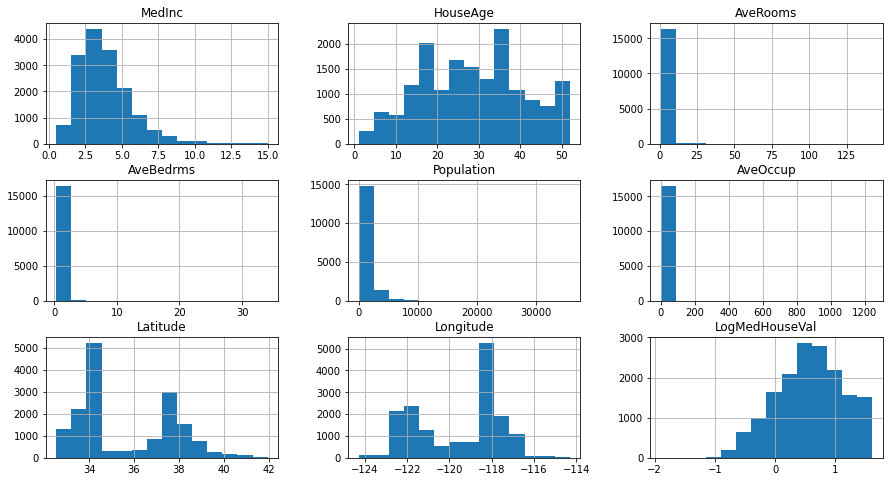

In [34]:
# Check some data
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['LogMedHouseVal'] = y_train
f, ax0 = plt.subplots(figsize=(15,8))
X_df.hist(bins=14, ax=ax0);

In [36]:
# Tune the hyperparameters
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],'max_depth': [4, 6],'min_samples_leaf': [3, 5, 9, 17], 
#'max_features': [1.0, 0.3, 0.1] ## not possible in our example (only 1 fx)
}

est = GradientBoostingRegressor(n_estimators=500)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
gs_cv.best_params_

KeyboardInterrupt: 

In [ ]:
# Create the regressor
est = GradientBoostingRegressor(n_estimators=200, max_depth=3, max_features=None, \
    max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,\
    learning_rate=0.04, loss='huber', random_state=0)



est.fit(X_train, y_train)

In [12]:
# Calculate the MAE
mae = mean_absolute_error(y_test, est.predict(X_test))
print('MAE: %.4f' % mae)

MAE: 0.1906


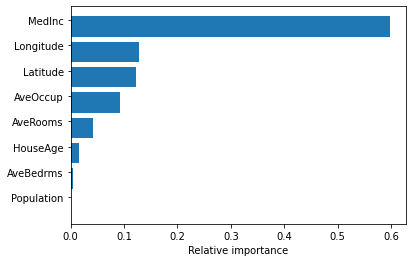

In [13]:
# sort importances
indices = np.argsort(est.feature_importances_)
# plot as bar chart
plt.barh(np.arange(len(names)), est.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('Relative importance')

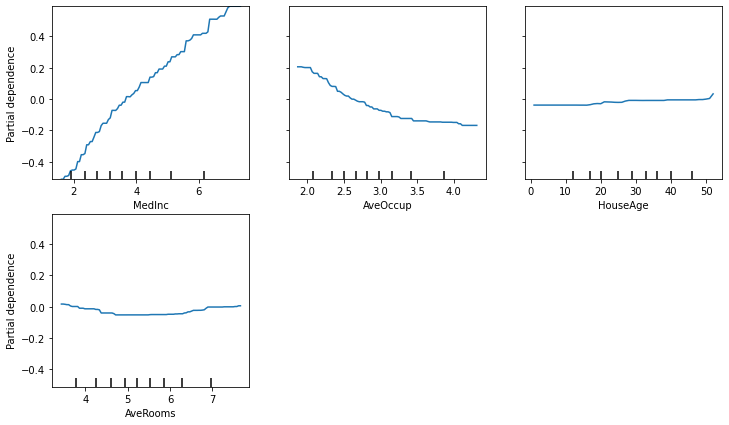

In [26]:
# See the partial dependency of "y" on one feature
features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms']
f, ax1 = plt.subplots(figsize=(12,7))
plot_partial_dependence(est, X_train, features,feature_names=names, ax = ax1);

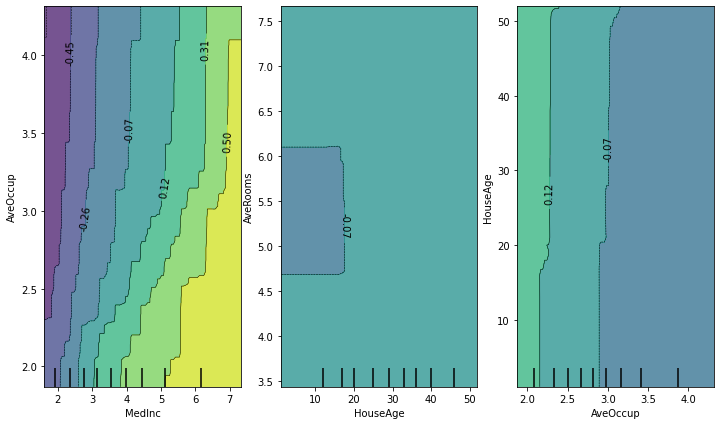

In [27]:
# See the partial dependency of "y" on two features
features2 = [('MedInc', 'AveOccup'), ('HouseAge', 'AveRooms'),('AveOccup', 'HouseAge')]
f, ax = plt.subplots(figsize=(12,7))
plot_partial_dependence(est, X_train, features2, feature_names=names, ax=ax);